In [39]:
import pickle
import os
import numpy as np
import torch
import pandas as pd

In [61]:
def add_to_dict(data_dict,data,filename):
    if filename in data_dict['fn']:
        print(f'File duplicated: {filename}' )
    else:
        data_dict['fn'].append(filename)
        L_list=np.arange(*data['args'].L)
        p_ctrl_list=np.round(np.linspace(data['args'].p_ctrl[0],data['args'].p_ctrl[1],int(data['args'].p_ctrl[2])),3)
        p_proj_list=np.round(np.linspace(data['args'].p_proj[0],data['args'].p_proj[1],int(data['args'].p_proj[2])),3)
        for key in ['O','EE','TMI']:
            for L_idx,L in enumerate(L_list):
                for p_ctrl_idx,p_ctrl in enumerate(p_ctrl_list):
                    for p_proj_idx,p_proj in enumerate(p_proj_list):
                            observations=data[key][L_idx,p_ctrl_idx,p_proj_idx]
                            if torch.is_tensor(observations):
                                observations=observations.cpu().tolist()
                            params=(key,L,p_ctrl,p_proj)
                            if params in data_dict:
                                data_dict[params]=data_dict[params]+observations
                            else:
                                data_dict[params]=observations
                    



In [62]:
data_dict={'fn':[]}

## pctrl [0,1,11], p_proj[0,0,1] L(8,10,2)

In [331]:
fn='CT_En2000_pctrl(0.00,1.00,11)_pproj(0.00,0.00,1)_L(8,10,2)_xj(1-3,2-3)_seed0_es2000_64.pickle'
with open(os.path.join('Data',fn),'rb') as f:
    data=pickle.load(f)
add_to_dict(data_dict, data,fn)

## pctrl [0,1,11], p_proj[0,0,1] L(10,14,2)

In [301]:
fn='CT_En2000_pctrl(0.00,1.00,11)_pproj(0.00,0.00,1)_L(10,14,2)_xj(1-3,2-3)_seed0_es2000_64.pickle'
with open(os.path.join('Data',fn),'rb') as f:
    data=pickle.load(f)
add_to_dict(data_dict, data,fn)

## pctrl [0,1,11], p_proj[0,0,1] L(14,16,2)

In [302]:
fn='CT_En2000_pctrl(0.00,1.00,11)_pproj(0.00,0.00,1)_L(14,16,2)_xj(1-3,2-3)_seed0_es2000_64.pickle'
with open(os.path.join('Data',fn),'rb') as f:
    data=pickle.load(f)
add_to_dict(data_dict, data,fn)

## pctrl [0,1,11], p_proj[0,0,1] L(16,18,2)

In [407]:
fn='CT_En2000_pctrl(0.00,1.00,11)_pproj(0.00,0.00,1)_L(16,18,2)_xj(1-3,2-3)_seed0_es2000_64.pickle'
with open(os.path.join('Data',fn),'rb') as f:
    data=pickle.load(f)
add_to_dict(data_dict, data,fn)

File duplicated: CT_En2000_pctrl(0.00,1.00,11)_pproj(0.00,0.00,1)_L(16,18,2)_xj(1-3,2-3)_seed0_es2000_64.pickle


## pctrl [0,1,11], p_proj[0,0,1] L(18,20,2)

In [304]:
for s in range(2):
    fn=f'CT_En1000_pctrl(0.00,1.00,11)_pproj(0.00,0.00,1)_L(18,20,2)_xj(1-3,2-3)_seed{s}_es1000_64.pickle'
    with open(os.path.join('Data',fn),'rb') as f:
        data=pickle.load(f)
    add_to_dict(data_dict, data,fn)

## pctrl [0,1,11], p_proj[0,0,1] L(20,22,2)

In [406]:
for s in range(2):
    for p_ctrl in np.linspace(0,1,11):
        fn=f'CT_En1000_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj(0.00,0.00,1)_L(20,22,2)_xj(1-3,2-3)_seed{s}_es1000_64.pickle'
        with open(os.path.join('Data',fn),'rb') as f:
            data=pickle.load(f)
        add_to_dict(data_dict, data,fn)

## pctrl [0,1,11], p_proj[0,0,1] L(22,24,2)

In [306]:
for s in range(10):
    for p_ctrl in np.linspace(0,1,11):
        fn=f'CT_En200_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj(0.00,0.00,1)_L(22,24,2)_xj(1-3,2-3)_seed{s}_es200_64.pickle'
        with open(os.path.join('Data',fn),'rb') as f:
            data=pickle.load(f)
        add_to_dict(data_dict, data,fn)

## pctrl [0,1,11], p_proj[0,0,1] L(24,26,2)

In [ ]:
for s in range(25):
    for p_ctrl in np.linspace(0,1,11):
        fn=f'CT_En80_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj(0.00,0.00,1)_L(24,26,2)_xj(1-3,2-3)_seed{s}_es80_64.pickle'
        try:
            with open(os.path.join('Data',fn),'rb') as f:
                data=pickle.load(f)
        except:
            print(f'File missing: {fn}')
        add_to_dict(data_dict, data,fn)

## pctrl [0,1,11], p_proj[0,1,11] L(10,12,2)

In [ ]:
for s in range(1):
    for p_ctrl in np.linspace(0,1,11)[1:]:
        for p_proj in np.linspace(0,1,11):
            fn=f'CT_En2000_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj({p_proj:.2f},{p_proj:.2f},1)_L(10,12,2)_xj(1-3,2-3)_seed{s}_es2000_64.pickle'
            try:
                with open(os.path.join('Data',fn),'rb') as f:
                    data=pickle.load(f)
                add_to_dict(data_dict, data,fn)
            except:
                print(f'File missing: {fn}')
            

## pctrl [0,.6,21], p_proj[0,.6,21] L(12,14,2)

In [64]:
for s in range(1):
    for p_ctrl in np.linspace(0,.6,21):
        for p_proj in np.linspace(0,.6,21):
            fn=f'CT_En2000_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj({p_proj:.2f},{p_proj:.2f},1)_L(12,14,2)_xj(1-3,2-3)_seed{s}_es2000_64.pickle'
            try:
                with open(fn,'rb') as f:
                # with open(os.path.join('Data',fn),'rb') as f:
                    data=pickle.load(f)
                add_to_dict(data_dict, data,fn)
            except:
                print(f'File missing: {fn}')
            

In [34]:
for s in range(1):
    for p_ctrl in np.linspace(0,.6,21):
        for p_proj in np.linspace(0,.6,21):
            fn=f'CT_En2000_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj({p_proj:.2f},{p_proj:.2f},1)_L(12,14,2)_xj(0)_seed{s}_es2000_64.pickle'
            try:
                with open(fn,'rb') as f:
                # with open(os.path.join('Data',fn),'rb') as f:
                    data=pickle.load(f)
                add_to_dict(data_dict, data,fn)
            except:
                print(f'File missing: {fn}')

## pctrl [0,1,11], p_proj[0,1,11] L(16,18,2)

In [65]:
for s in range(1):
    for p_ctrl in np.linspace(0,.6,21):
        for p_proj in np.linspace(0,.6,21):
            fn=f'CT_En2000_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj({p_proj:.2f},{p_proj:.2f},1)_L(16,18,2)_xj(1-3,2-3)_seed{s}_es2000_64.pickle'
            try:
                with open(fn,'rb') as f:
                # with open(os.path.join('Data',fn),'rb') as f:
                    data=pickle.load(f)
            except:
                print(f'File missing: {fn}')
            add_to_dict(data_dict, data,fn)

In [35]:
for s in range(1):
    for p_ctrl in np.linspace(0,.6,21):
        for p_proj in np.linspace(0,.6,21):
            fn=f'CT_En2000_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj({p_proj:.2f},{p_proj:.2f},1)_L(16,18,2)_xj(0)_seed{s}_es2000_64.pickle'
            try:
                with open(fn,'rb') as f:
                # with open(os.path.join('Data',fn),'rb') as f:
                    data=pickle.load(f)
                add_to_dict(data_dict, data,fn)
            except:
                print(f'File missing: {fn}')

## pctrl [0,1,11], p_proj[0,1,11] L(20,22,2)

In [66]:
for s in range(2):
    for p_ctrl in np.linspace(0,.6,21):
        for p_proj in np.linspace(0,.6,21):
            fn=f'CT_En1000_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj({p_proj:.2f},{p_proj:.2f},1)_L(20,22,2)_xj(1-3,2-3)_seed{s}_es1000_64.pickle'
            try:
                with open(fn,'rb') as f:
                # with open(os.path.join('Data',fn),'rb') as f:
                    data=pickle.load(f)
                add_to_dict(data_dict, data,fn)
            except:
                print(f'File missing: {fn}')
            

File missing: CT_En1000_pctrl(0.00,0.00,1)_pproj(0.00,0.00,1)_L(20,22,2)_xj(1-3,2-3)_seed0_es1000_64.pickle
File missing: CT_En1000_pctrl(0.00,0.00,1)_pproj(0.03,0.03,1)_L(20,22,2)_xj(1-3,2-3)_seed0_es1000_64.pickle
File missing: CT_En1000_pctrl(0.00,0.00,1)_pproj(0.06,0.06,1)_L(20,22,2)_xj(1-3,2-3)_seed0_es1000_64.pickle
File missing: CT_En1000_pctrl(0.00,0.00,1)_pproj(0.09,0.09,1)_L(20,22,2)_xj(1-3,2-3)_seed0_es1000_64.pickle
File missing: CT_En1000_pctrl(0.00,0.00,1)_pproj(0.12,0.12,1)_L(20,22,2)_xj(1-3,2-3)_seed0_es1000_64.pickle
File missing: CT_En1000_pctrl(0.00,0.00,1)_pproj(0.15,0.15,1)_L(20,22,2)_xj(1-3,2-3)_seed0_es1000_64.pickle
File missing: CT_En1000_pctrl(0.00,0.00,1)_pproj(0.18,0.18,1)_L(20,22,2)_xj(1-3,2-3)_seed0_es1000_64.pickle
File missing: CT_En1000_pctrl(0.00,0.00,1)_pproj(0.21,0.21,1)_L(20,22,2)_xj(1-3,2-3)_seed0_es1000_64.pickle
File missing: CT_En1000_pctrl(0.00,0.00,1)_pproj(0.24,0.24,1)_L(20,22,2)_xj(1-3,2-3)_seed0_es1000_64.pickle
File missing: CT_En1000_pctr

In [36]:
for s in range(2):
    for p_ctrl in np.linspace(0,.6,21):
        for p_proj in np.linspace(0,.6,21):
            fn=f'CT_En1000_pctrl({p_ctrl:.2f},{p_ctrl:.2f},1)_pproj({p_proj:.2f},{p_proj:.2f},1)_L(20,22,2)_xj(0)_seed{s}_es1000_64.pickle'
            try:
                with open(fn,'rb') as f:
                # with open(os.path.join('Data',fn),'rb') as f:
                    data=pickle.load(f)
            except:
                print(f'File missing: {fn}')
            add_to_dict(data_dict, data,fn)
            

File missing: CT_En1000_pctrl(0.09,0.09,1)_pproj(0.21,0.21,1)_L(20,22,2)_xj(0)_seed1_es1000_64.pickle
File missing: CT_En1000_pctrl(0.09,0.09,1)_pproj(0.51,0.51,1)_L(20,22,2)_xj(0)_seed1_es1000_64.pickle
File missing: CT_En1000_pctrl(0.48,0.48,1)_pproj(0.30,0.30,1)_L(20,22,2)_xj(0)_seed1_es1000_64.pickle


## Convert to pandas

In [67]:
def convert_pd(data_dict):
    index = pd.MultiIndex.from_tuples([key for key in data_dict.keys() if key!='fn'], names=['Metrics','L', 'p_ctrl', 'p_proj'])
    df = pd.DataFrame({'observations': [val for key,val in data_dict.items() if key!='fn']}, index=index)
    return df



In [68]:
df=convert_pd(data_dict)

In [41]:
import matplotlib.pyplot as plt

Text(0.5, 0, '$p_{ctrl}$')

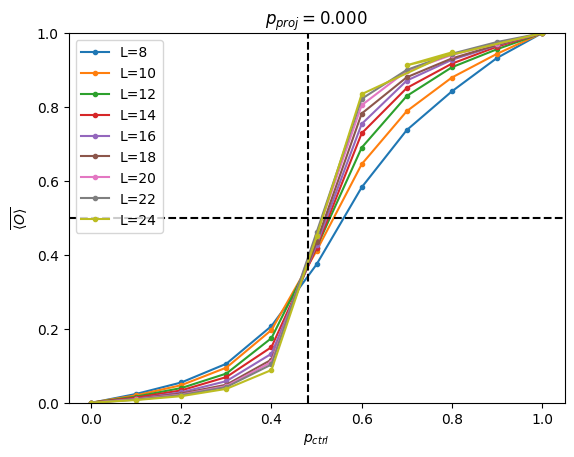

In [318]:
fig,ax=plt.subplots()
for L in df.index.get_level_values('L').unique():
    dd=df.xs(key='O',level='Metrics').xs(key=L,level='L')['observations'].apply(lambda obs: sum(obs) / len(obs) if obs else None)
    ax.plot(dd.index.get_level_values('p_ctrl'),dd,'.-',label=f'L={L}')
    # ax.plot(p_ctrl_list,data['O'][i,:,p_proj_idx].mean(axis=-1),'.-',label=f'L={L_list[i]}')
ax.legend()
ax.axvline(x=0.48,ls='dashed',color='k')
ax.axhline(y=0.5,ls='dashed',color='k')
# ax.set_xlim([.2,.8])
ax.set_ylim([0,1])
ax.set_title(f'$p_{{proj}}={p_proj_list[p_proj_idx]:.3f}$')
ax.set_ylabel(r'$\overline{\langle O \rangle}$')
ax.set_xlabel('$p_{ctrl}$')

In [ ]:
subset = df.xs(key=0, level='first_index')  # Slicing by first index


In [79]:
# Access data by slicing
subset = df.xs(key=0, level='first_index')  # Slicing by first index
print(subset)


                          observations
second_index third_index              
0            0               [1, 2, 3]
             1                  [4, 5]
1            0            [6, 7, 8, 9]


In [84]:
subset=df.loc[(0,slice(None),0),:]

In [85]:
subset

observations
first_index second_index third_index              
0           0            0               [1, 2, 3]
            1            0            [6, 7, 8, 9]

In [86]:

# Compute mean over the observations in the slice
mean_values = subset['observations'].apply(lambda obs: sum(obs) / len(obs) if obs else None)
print(mean_values)

first_index  second_index  third_index
0            0             0              2.0
             1             0              7.5
Name: observations, dtype: float64


## Plot

In [69]:
dd_O={L:df.xs(key='O',level='Metrics').xs(key=L,level='L')['observations'].apply(lambda obs: sum(obs) / len(obs) if obs else None) for L in [12,16,20]}

In [70]:
dd_TMI={L:df.xs(key='TMI',level='Metrics').xs(key=L,level='L')['observations'].apply(lambda obs: sum(obs) / len(obs) if obs else None) for L in [12,16,20]}

In [71]:
diff_O=(dd_O[16]-dd_O[20]).dropna()

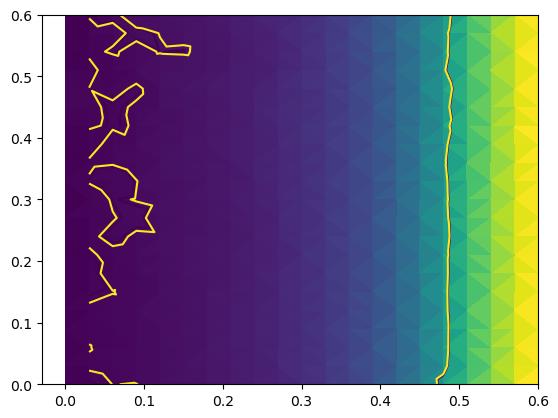

In [73]:
plt.tripcolor(dd_O[12].index.get_level_values('p_ctrl'),dd_O[12].index.get_level_values('p_proj'),dd_O[12])
plt.tricontour(diff_O.index.get_level_values('p_ctrl'),diff_O.index.get_level_values('p_proj'),diff_O,levels=[0,0.001],)


In [76]:
diff_TMI=(dd_TMI[16]-dd_TMI[20]).dropna()

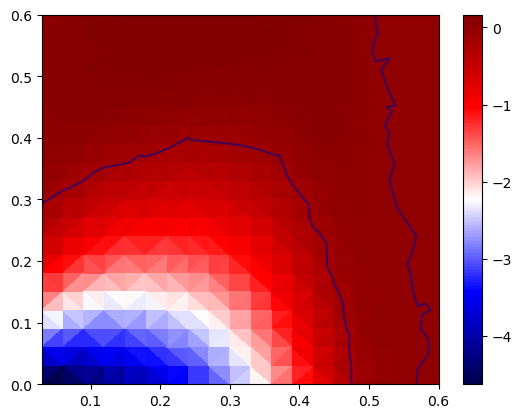

In [78]:
plt.tripcolor(dd_TMI[20].index.get_level_values('p_ctrl'),dd_TMI[20].index.get_level_values('p_proj'),(dd_TMI[20]),cmap='seismic',)
plt.colorbar()
plt.tricontour(diff_TMI.index.get_level_values('p_ctrl'),diff_TMI.index.get_level_values('p_proj'),diff_TMI,levels=[0,],)


# xj=0

In [50]:
dd_O={L:df.xs(key='O',level='Metrics').xs(key=L,level='L')['observations'].apply(lambda obs: sum(obs) / len(obs) if obs else None) for L in [12,16,20]}

In [51]:
dd_TMI={L:df.xs(key='TMI',level='Metrics').xs(key=L,level='L')['observations'].apply(lambda obs: sum(obs) / len(obs) if obs else None) for L in [12,16,20]}

In [52]:
diff_O=(dd_O[12]-dd_O[16]).dropna()

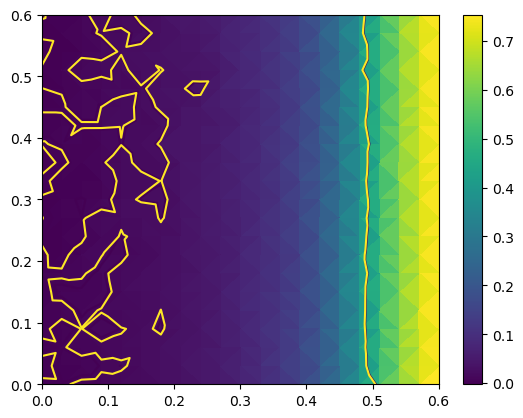

In [55]:
plt.tripcolor(dd_O[12].index.get_level_values('p_ctrl'),dd_O[12].index.get_level_values('p_proj'),dd_O[12])
plt.colorbar()
plt.tricontour(diff_O.index.get_level_values('p_ctrl'),diff_O.index.get_level_values('p_proj'),diff_O,levels=[0,0.001],)

In [59]:
diff_TMI=(dd_TMI[16]-dd_TMI[20]).dropna()

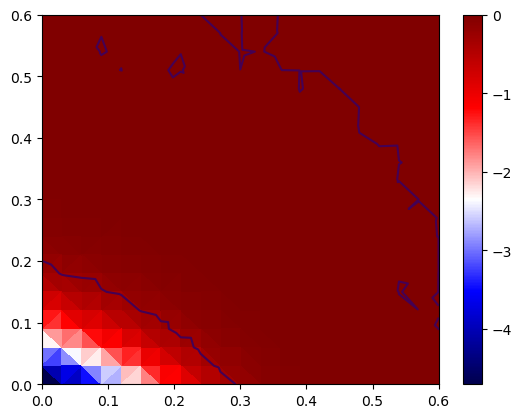

In [60]:
plt.tripcolor(dd_TMI[20].index.get_level_values('p_ctrl'),dd_TMI[20].index.get_level_values('p_proj'),(dd_TMI[20]),cmap='seismic',)
plt.colorbar()
plt.tricontour(diff_TMI.index.get_level_values('p_ctrl'),diff_TMI.index.get_level_values('p_proj'),diff_TMI,levels=[0,],)
